In [1]:
%pip install tensorflow
%pip install imageio


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

2025-01-25 16:16:14.841339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 16:16:14.848306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737839774.856411   15205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737839774.858811   15205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 16:16:14.867529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
image_dim = 256
image_channels = 3

# Dataset and Objective
The images are 3x256x256 JPEGS. There are 300 Monet paintings and 7038 real world images.

The task is to use a GAN to generate Monet-like paintings from real world images.

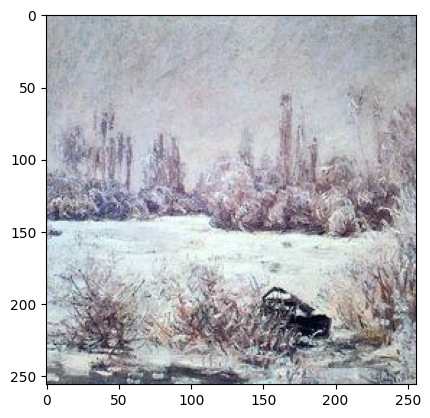

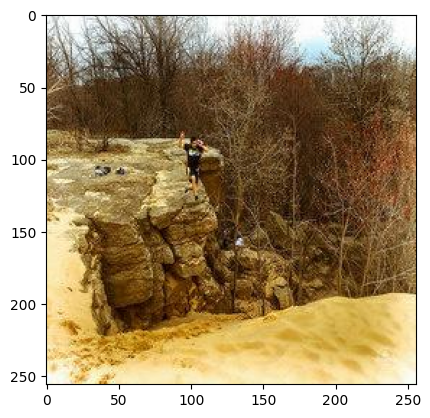

In [4]:
# print example images
monet_dir = "monet_jpg"
photo_dir = "photo_jpg"

from display_random_image import display_random_image

display_random_image(monet_dir)
display_random_image(photo_dir)

# The Training Images
Here will load the training images.

In [5]:
# combine the 300 monet images with 300 random photos to make the training dataset
# target labels are 1 for monet and 0 for photo
import os
from PIL import Image
import tensorflow as tf


def get_train_images(dir):
    image_filenames = os.listdir(dir)
    dataset = []

    # load all images
    for image in image_filenames:
        image_path = os.path.join(dir, image)
        image = Image.open(image_path)
        dataset.append(np.array(image))

    # tensor
    dataset = tf.convert_to_tensor(dataset, dtype=tf.float32)

    return dataset


true_monet_images = get_train_images(monet_dir)

2025-01-25 16:16:16.205312: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
# 300 monet images
BUFFER_SIZE = 300
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def resize(input_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image

In [8]:
def random_crop(input_image, height=256, width=256, channels=3):
    cropped_image = tf.image.random_crop(input_image, size=[height, width, channels])
    return cropped_image

In [9]:
# Normalizing the images to [-1, 1]
def normalize(input_image):
    input_image = (input_image / 127.5) - 1

    return input_image

In [10]:
@tf.function()
def random_jitter(input_image, resize_height=286, resize_width=286, crop_height=256, crop_width=256):
    # Resizing to 286x286
    input_image = resize(input_image, resize_height, resize_width)

    # Random cropping back to 256x256
    input_image = random_crop(input_image, crop_height, crop_width)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)

    return input_image

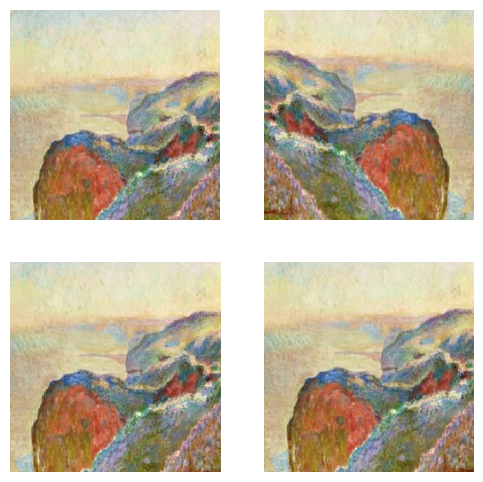

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
    pic = random_jitter(true_monet_images[0])
    plt.subplot(2, 2, i + 1)
    plt.imshow(pic / 255.0)
    plt.axis("off")
plt.show()

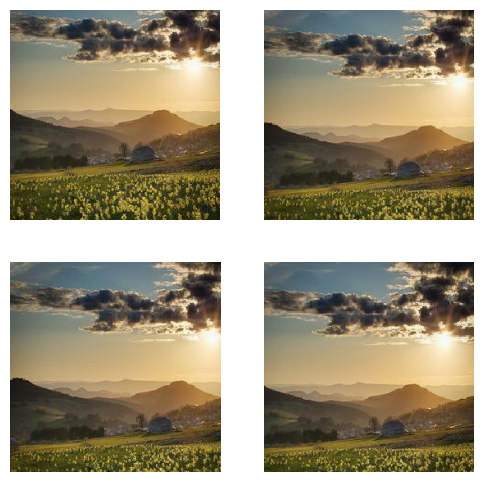

In [12]:
photo_images = get_train_images(photo_dir)
plt.figure(figsize=(6, 6))
for i in range(4):
    pic = random_jitter(photo_images[0])
    plt.subplot(2, 2, i + 1)
    plt.imshow(pic / 255.0)
    plt.axis("off")
plt.show()